# Cyclistic Bike-Share Analysis 
## Capstone Project

**Author:** Your Name  
**Date:** [Month, Year]

---

## 1. Introduction

**Case Study:** [How Does a Bike-Share Navigate Speedy Success?]()

Cyclistic is a fictional bike-share company in Chicago. The company offers single-ride passes, full-day passes, and annual memberships. Customers who purchase single-ride or full-day passes are called **casual riders**, while those who purchase annual memberships are known as **members**. Based on data from the last 12 months, we want to analyze **how annual members and casual riders use Cyclistic bikes differently**. 

**Business Task**  
- Understand how different types of customers use Cyclistic bike-share.  
- Identify insights that will help the marketing team design strategies aimed at converting casual riders into annual members.  

**Key Stakeholders**  
- **Cyclistic Executive Team**: Final decision-makers who approve marketing strategies.  
- **Director of Marketing (Lily Moreno)**: Oversees campaigns and initiatives to promote the bike-share program.  
- **Cyclistic Marketing Analytics Team**: Responsible for analyzing data and providing actionable insights (our role).

---


## 2. Ask

We follow the “Ask” phase of the data analysis process.

### Guiding Questions
1. How do annual members and casual riders use Cyclistic bikes differently?  
2. Why would casual riders buy Cyclistic annual memberships?  
3. How can Cyclistic use digital media to influence casual riders to become members?  

We will focus on the **first** question:
> **How do annual members and casual riders use Cyclistic bikes differently?**

Our answers will be used to guide the marketing strategy for turning casual riders into annual members.

---


## 3. Prepare

**Data Source**  
We are using the [Cyclistic’s historical trip data](). This data is public and can be downloaded from Divvy’s official site. (For demonstration, we’ll assume we have CSV files for the past 12 months in a single folder.)

**File Organization**  
- 12 CSV files named like:  
  - `2024_01_divvy_tripdata.csv`  
  - `2024_02_divvy_tripdata.csv`  
  - …  
  - `2024_12_divvy_tripdata.csv`

**Privacy and Licenses**  
- Rider IDs are anonymized, so we cannot track personal info.  
- Data is provided by Motivate International Inc. under a license that prohibits using personally identifiable information.  

**Credibility**  
- Data seems reliable and current. However, we should note potential sampling or data-entry errors.  

**Plan**  
- We will combine the 12 months of data into one DataFrame.  
- We will remove or correct invalid records.  
- We will generate new columns (ride length, day of week, etc.) for analysis.  

---

In [2]:
# 4. Process

# =========================
# 4.1 Import Libraries
# =========================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import zipfile

# Setting a style for plots
sns.set_style("whitegrid")

# =========================
# 4.2 Load and Combine Data
# =========================
# NOTE: Replace file paths with the actual paths to your 12 CSVs.
# Example: We'll just make a list of CSV filenames and read them in a loop.

# Glob pattern to find all CSV files in the 'data' folder
base_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
data_dir = base_dir / 'data'
zip_files = list(data_dir.glob('*.zip'))

df_list = []
for file in zip_files:
    with zipfile.ZipFile(file, 'r') as z:
        # List files and exclude macOS metadata
        csv_files = [f for f in z.namelist() if f.endswith('.csv') and '__MACOSX/' not in f]
    
        if len(csv_files) == 1:
            temp_df = pd.read_csv(z.open(csv_files[0]))
            df_list.append(temp_df)
        else:
            raise ValueError(f"Found multiple CSV files: {csv_files}")

# Combine into a single DataFrame
bike_df = pd.concat(df_list, ignore_index=True)

# Confirm the results
print(f"Found {len(zip_files)} zip files in {data_dir}")
print(f"Found {len(df_list)} CSV files in total.")
print(f"Combined DataFrame has {bike_df.shape[0]} rows and {bike_df.shape[1]} columns.")

# =========================
# 4.3 Data Cleaning
# =========================

# 1) Drop duplicates if any
bike_df.drop_duplicates(inplace=True)

# 2) Remove any NA in critical columns (e.g., start_time, end_time)
bike_df.dropna(subset=['started_at', 'ended_at', 'member_casual'], inplace=True)




Found 12 zip files in c:\GitHub\technical_challenge\capstone-google-data-analytics\data
Found 12 CSV files in total.
Combined DataFrame has 5860568 rows and 13 columns.


In [3]:
# Add ".0" to entries without milliseconds
bike_df['started_at'] = bike_df['started_at'].str.replace(
    r'(\d{2}:\d{2}:\d{2})(?!\.\d+)',  # Regex: Match time without milliseconds
    r'\1.0',  # Append ".0"
    regex=True
)
bike_df['ended_at'] = bike_df['ended_at'].str.replace(
    r'(\d{2}:\d{2}:\d{2})(?!\.\d+)',  # Regex: Match time without milliseconds
    r'\1.0',  # Append ".0"
    regex=True
)

In [4]:
# 3) Convert start and end times to datetime
bike_df['started_at'] = pd.to_datetime(bike_df['started_at'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
bike_df['ended_at'] = pd.to_datetime(bike_df['ended_at'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

In [5]:
# 4) Create new columns: ride_length, day_of_week
bike_df['ride_length'] = bike_df['ended_at'] - bike_df['started_at']
bike_df['day_of_week'] = bike_df['started_at'].dt.day_name()

# 5) Filter out negative or zero ride lengths if present
bike_df = bike_df[bike_df['ride_length'] > pd.Timedelta(seconds=0)]

# Confirm final structure
print(bike_df.info())
print(bike_df.head(3))

# We'll also check for potential outliers, e.g., rides longer than 24h
long_rides = bike_df[bike_df['ride_length'] > pd.Timedelta(hours=24)]
print(f"Number of rides > 24h: {long_rides.shape[0]}")

<class 'pandas.core.frame.DataFrame'>
Index: 5859845 entries, 0 to 5860567
Data columns (total 15 columns):
 #   Column              Dtype          
---  ------              -----          
 0   ride_id             object         
 1   rideable_type       object         
 2   started_at          datetime64[ns] 
 3   ended_at            datetime64[ns] 
 4   start_station_name  object         
 5   start_station_id    object         
 6   end_station_name    object         
 7   end_station_id      object         
 8   start_lat           float64        
 9   start_lng           float64        
 10  end_lat             float64        
 11  end_lng             float64        
 12  member_casual       object         
 13  ride_length         timedelta64[ns]
 14  day_of_week         object         
dtypes: datetime64[ns](2), float64(4), object(8), timedelta64[ns](1)
memory usage: 715.3+ MB
None
            ride_id  rideable_type          started_at            ended_at  \
0  C1D650626C8C899A

### Process Documentation

**Summary of Cleaning Steps**  
1. **Combined** 12 monthly CSV files into a single DataFrame (`bike_df`).  
2. **Removed duplicates**.  
3. **Removed NA** values in critical columns.  
4. **Converted** `started_at` and `ended_at` to datetime.  
5. Created **`ride_length`** as `ended_at - started_at`.  
6. Created **`day_of_week`** using `dt.day_name()`.  
7. Filtered out negative or zero ride lengths.  

These steps ensure our data is clean and ready for analysis.

---


## 5. Analyze

We now explore and summarize the data to uncover how casual riders and annual members differ.

**Possible questions**:
1. What is the average ride length for each user type?  
2. What days of the week do different user types ride the most?  
3. Which months experience the highest usage?

We can use Python’s `groupby()` functions to answer these questions.

---


In [6]:
# 5. Analyze

# =========================
# 5.1 Summary Statistics
# =========================
# Convert ride_length to numeric (in minutes) for convenience
bike_df['ride_length_minutes'] = bike_df['ride_length'].dt.total_seconds() / 60

# Group by user type
summary_stats = bike_df.groupby('member_casual')['ride_length_minutes'].agg(['mean','median','max','count'])
print("Ride Length (minutes) by User Type:\n", summary_stats)

# =========================
# 5.2 Day-of-week analysis
# =========================
dow_stats = bike_df.groupby(['member_casual','day_of_week'])['ride_length_minutes'].mean().reset_index()
dow_counts = bike_df.groupby(['member_casual','day_of_week'])['ride_id'].count().reset_index()

print("\nAverage Ride Length (minutes) by User Type and Day of Week:\n", dow_stats)
print("\nRide Count by User Type and Day of Week:\n", dow_counts)

# =========================
# 5.3 Month analysis
# =========================
bike_df['month'] = bike_df['started_at'].dt.month_name()
month_stats = bike_df.groupby(['member_casual','month'])['ride_id'].count().reset_index()
print("\nMonthly Ride Count:\n", month_stats)


Ride Length (minutes) by User Type:
                     mean     median          max    count
member_casual                                            
casual         25.154473  12.055500  1559.933333  2151397
member         12.773548   8.695117  1559.800000  3708448

Average Ride Length (minutes) by User Type and Day of Week:
    member_casual day_of_week  ride_length_minutes
0         casual      Friday            24.529602
1         casual      Monday            24.140645
2         casual    Saturday            28.196084
3         casual      Sunday            29.424696
4         casual    Thursday            21.910400
5         casual     Tuesday            21.516002
6         casual   Wednesday            22.279592
7         member      Friday            12.425107
8         member      Monday            12.211676
9         member    Saturday            14.078281
10        member      Sunday            14.274930
11        member    Thursday            12.258676
12        member   

### Preliminary Observations

- **Average Ride Length**: If `mean` for casual riders >> `mean` for annual members, that suggests casual riders have longer leisure trips.  
- **Ride Count**: We may see that members ride more frequently overall.  
- **Day of Week**: We might see casual riders using bikes more on weekends vs. members using them for weekday commutes.  

We will visualize these findings next.

---


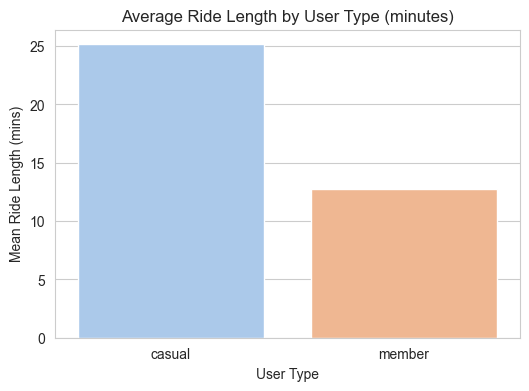

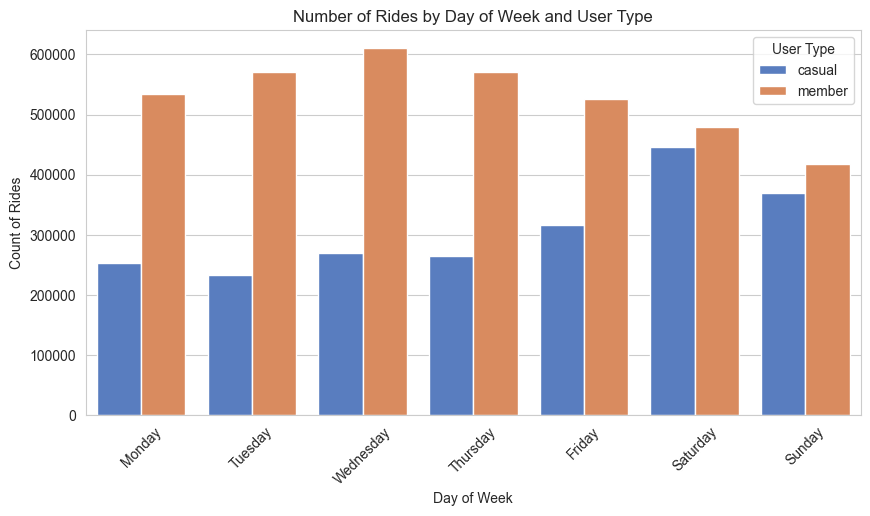

In [7]:
## 6. Share: Visualizations

import matplotlib.pyplot as plt
import seaborn as sns

# Let's visualize average ride length by user type
avg_ride_length = (
    bike_df
    .groupby('member_casual')['ride_length_minutes']
    .mean()
    .reset_index()
)
plt.figure(figsize=(6,4))
# sns.barplot(data=avg_ride_length, x='member_casual', y='ride_length_minutes', palette='pastel')

sns.barplot(
    data=avg_ride_length, 
    x='member_casual', 
    y='ride_length_minutes',
    hue='member_casual',       # This assigns colors by the same category
    dodge=False,               # Ensures bars overlap (instead of side-by-side)
    palette='pastel'
)
# Optionally remove the redundant legend:

plt.title("Average Ride Length by User Type (minutes)")
plt.xlabel("User Type")
plt.ylabel("Mean Ride Length (mins)")
plt.show()

# Ride count by day of week
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_counts_plot = (
    bike_df
    .groupby(['member_casual','day_of_week'])['ride_id']
    .count()
    .reset_index()
)
dow_counts_plot['day_of_week'] = pd.Categorical(dow_counts_plot['day_of_week'], categories=dow_order, ordered=True)

plt.figure(figsize=(10,5))
sns.barplot(data=dow_counts_plot, x='day_of_week', y='ride_id', hue='member_casual', palette='muted')
plt.title("Number of Rides by Day of Week and User Type")
plt.xlabel("Day of Week")
plt.ylabel("Count of Rides")
plt.xticks(rotation=45)
plt.legend(title='User Type')
plt.show()


### Key Findings

1. **Ride Length**: If the bar chart shows that casual riders have a significantly higher average ride length than members, it suggests that casual riders use the bikes more for leisurely or long weekend rides.
2. **Day of Week**: If casual riders’ usage spikes on Saturday and Sunday, that again suggests leisure. Members might have consistent usage across weekdays, pointing to work commutes.
3. **Volume**: Members might have a higher *count* of rides overall, even if their rides are typically shorter.

These visuals are critical to convincing stakeholders and forming the basis of our recommendations.

---


## 7. Act

Based on our findings, here are our **top three recommendations** for converting casual riders into members:

1. **Weekend Leisure Campaign**  
   - Because casual riders are more active on weekends and take longer leisure rides, we can introduce a “Weekend Membership Offer” that provides discounted membership or special perks for those who frequently ride on weekends.

2. **Highlight Cost Savings**  
   - Emphasize how frequent or longer rides can be more cost-effective with an annual membership compared to multiple single-ride passes.

3. **Targeted Digital Ads**  
   - Use social media and email campaigns, focusing on casual riders who took multiple weekend rides in the past. Show them data about how many rides they took and how much they could have saved by becoming a member.

**Next Steps**:
- Launch a marketing test campaign for a month, then measure conversion rates from casual to member.
- Gather feedback from new members to refine messaging.
- Explore offering loyalty points or gamification for repeated weekend rides.

---


## 8. Conclusion and Next Steps

### Conclusion

- **Problem Summary**: Cyclistic wants to maximize the number of annual memberships by converting casual riders.  
- **Key Insight**: Casual riders have significantly longer ride durations, typically on weekends. Members tend to have shorter, more frequent rides, often on weekdays.  
- **Business Impact**: Marketing efforts that highlight cost savings and convenience for frequent/weekend riders will help drive casual riders toward membership.

### Next Steps

1. **Implement** targeted marketing and promotional offers to casual riders.  
2. **Monitor** membership sign-up rates and usage patterns for changes.  
3. **Validate** with further data analysis after the marketing campaign runs.

This concludes our **Cyclistic Bike-Share Analysis** case study. We have identified potential strategies to convert casual riders into annual members based on data-driven insights.

---
